In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-top-800-moviescsv/imdb_top_800_movies.csv
/kaggle/input/cleaned/imdb_top_800_cleaned.csv


# <span style="color:DarkCyan">**Movie Recommendation Model**<span>

![](https://www.reliancedigital.in/wp-content/uploads/2019/02/netflix_movies_cover.jpg)

# <span style="color:DarkCyan">**Content**<span>
- [Introduction](#Introduction) <a href = '#Introduction'></a>
- [Web Scraping](#Web-Scraping) <a href = '#Web-Scraping'></a>   
- [Data](#Data) <a href = '#Data'></a>
- [Loading Data](#Loading-Data) <a href = '#Loading-Data'></a>
- [Model](#Model) <a href = '#Model'></a>
- [Features](#Features) <a href = '#Features'></a>
- [Conclusion](#Conclusion) <a href = '#Conclusion'></a>

# <span style="color:DarkCyan">**<a id='Introduction'>Introduction</a>**<span>

Recommendation Systems in the world of machine learning have become very popular and are a huge advantage to tech giants like Netflix, Amazon and many more to target their content to a specific audience. 

These recommendation engines are so strong in their predictions that they can dynamically alter the state of what the user sees on their page based on the user’s interaction with the app

# <span style="color:DarkCyan">**<a id='Web-Scraping'>Web Scraping</a>**<span>

The dataset we’ll use in this project is scraped from imdb.com.

My choice of web scraper tool for this project is Selenium.

I can't run the script on Kaggle. But I'll leave the script for you to see how I got the data.

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import csv

path = "path_to_chrome_driver"
driver = webdriver.Chrome(path)

# Function to scrape informations from movie
def scrape_movie():

    try:
        title = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CLASS_NAME, "title_wrapper"))
        )
        movie_title = title.text

        rating = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CLASS_NAME, "imdbRating"))
        )
        movie_rating = rating.text

        duration = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='title-overview-widget']/div[1]/div[2]/div/div[2]/div[2]/div/time"))
        )
        movie_duration = duration.text

        genre = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='title-overview-widget']/div[1]/div[2]/div/div[2]/div[2]/div/a[1]"))
        )
        movie_genre = genre.text

        summary = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CLASS_NAME, "summary_text"))
        )
        movie_summary = summary.text

        year = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, "titleYear"))
        )
        movie_release = year.text

        credits = WebDriverWait(driver, 30).until(
            EC.presence_of_all_elements_located((By.CLASS_NAME, "credit_summary_item"))
        )
        director = credits[0].text
        writers = credits[1].text
        stars = credits[2].text

        keywords = WebDriverWait(driver, 30).until(
            EC.presence_of_all_elements_located((By.CLASS_NAME, "itemprop"))
        )
        keywords_of_movie = []
        for i in keywords:
            keywords_of_movie.append(i.text)

        movie = (movie_title,movie_rating,director,writers,stars,keywords_of_movie,movie_duration,movie_genre,movie_release,movie_summary)
        driver.back()

        return movie

    except:
        driver.quit()


driver.get("https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start=0&ref_=adv_nxt")

scraped_movies = []

# Start of every page is increased by 50. So, start of 1st page is 1, 2nd is 51, 3rd is 101,...
start_page = []
start_page.append(0)
number = 1
for i in range(16):
    number += 50
    start_page.append(number)

page = 0
while page < 14:
    for i in range(0,50): #0,50
        try:
            items = WebDriverWait(driver, 30).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, "loadlate"))
            )

            items[i].click()
            movie_scraped = scrape_movie()
            scraped_movies.append(movie_scraped)

        except:
            driver.implicitly_wait(5)
    page+=1
    new_link = "https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start={}&ref_=adv_nxt".format(start_page[page])
    driver.get(new_link)

with open("imdb_top_800_movies_4.csv", "w", newline='',encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["Title","Rating","Director","Writers","Stars","Keywords","Movie_Duration","Genre","Release_Year","Description"])
    writer.writerows(scraped_movies)

ModuleNotFoundError: No module named 'selenium'

*Basically, it goes to imdb top 1000 movies. Every page has 50 movies. It goes in every movie individually, scrape the data about Title, Duration, Rating, Writers, Stars, Directors, Keywords and Description. After finising 50 movies, link is automatically being changed for the next page, and same process happens again and again until the end of while loop.*

**NOTE: I can't scrape data from Kaggle. I left this code here so you can see how I got the data.**

# <span style="color:DarkCyan">**<a id='Data'>Data</a>**<span>

### Data contains columns such as: 
* Title
* Rating
* Director
* Writers
* Stars
* Keywords
* Movie duration
* Genre
* Release Year
* Description

**For now the data is raw. We will focus on data cleansing first.**

# <span style="color:DarkCyan">**<a id='Loading-Data'>Loading Data</a>**<span>

In [3]:
import pandas as pd

df = pd.read_csv('/kaggle/input/imdb-top-800-moviescsv/imdb_top_800_movies.csv', encoding='ISO-8859-1')
print(df.head())

                                               Title           Rating  \
0  Wild Tales (2014)\rRelatos salvajes (original ...  8.1/10\r172,423   
1  Winter Sleep (2014)\rKis Uykusu (original titl...   8.1/10\r44,405   
2  Baahubali: The Beginning (2015)\rBí£hubali: Th...  8.1/10\r100,816   
3  Gully Boy (2019)\rNot Rated | 2h 33min | Drama...   8.1/10\r30,297   
4  PK (2014)\rNot Rated | 2h 33min | Comedy, Dram...  8.1/10\r158,678   

                      Director  \
0    Director: Damiíçn Szifron   
1  Director: Nuri Bilge Ceylan   
2     Director: S.S. Rajamouli   
3        Director: Zoya Akhtar   
4    Director: Rajkumar Hirani   

                                             Writers  \
0  Writers: Germíçn Servidio (collaborating write...   
1  Writers: Ebru Ceylan, Nuri Bilge Ceylan | 1 mo...   
2  Writers: Vijayendra Prasad (story by), S.S. Ra...   
3  Writers: Zoya Akhtar, Reema Kagti | 1 more cre...   
4            Writers: Rajkumar Hirani, Abhijat Joshi   

                   

In [4]:
print(df.dtypes)

Title             object
Rating            object
Director          object
Writers           object
Stars             object
Keywords          object
Movie_Duration    object
Genre             object
Release_Year       int64
Description       object
dtype: object


**As you can see, we'll have to deal with special characters in data, data types(converting object to int/float), creating new columns in data such as 'Number_Of_Ratings'(extract from column Rating) and change the format of 'Movie_Duration' to minutes. Because, we can't use format of '2h30min' in our model, so '2h30min' would be 150(min).**

**I'll start with cleaning Title, Directors, Writers and Stars columns. Because those columns have similar format problem. They all have unnecessary brackets, dots, etc ...**

In [5]:
df["Title"] = df["Title"].apply(lambda x: x.split("(")[0])
df["Director"] = df["Director"].apply(lambda x: x.split(":")[1])
df["Writers"] = df["Writers"].apply(lambda x: x.split(":")[1].split("|")[0].split("(")[0])
df["Stars"] = df["Stars"].apply(lambda x: x.split(":")[0].split("|")[0])
df.head()

,Title,Rating,Director,Writers,Stars,Keywords,Movie_Duration,Genre,Release_Year,Description
0,Wild Tales,"8.1/10\r172,423",Damiíçn Szifron,Germíçn Servidio,Stars,"['anthology film', 'suicide by airplane crash'...",2h 2min,Comedy,-2014,Six short stories that explore the extremities...
1,Winter Sleep,"8.1/10\r44,405",Nuri Bilge Ceylan,"Ebru Ceylan, Nuri Bilge Ceylan",Stars,"['throwing a stone at a car', 'husband wife re...",3h 16min,Drama,-2014,A hotel owner and landlord in a remote Turkish...
2,Baahubali: The Beginning,"8.1/10\r100,816",S.S. Rajamouli,Vijayendra Prasad,Stars,"['india', 'kingdom', 'dual role', 'hindu', 'go...",2h 39min,Action,-2015,"In ancient India, an adventurous and daring ma..."
3,Gully Boy,"8.1/10\r30,297",Zoya Akhtar,"Zoya Akhtar, Reema Kagti",Stars,"['rapper', 'singer', 'success', 'love', 'frien...",2h 33min,Drama,-2019,A coming-of-age story based on the lives of st...
4,PK,"8.1/10\r158,678",Rajkumar Hirani,"Rajkumar Hirani, Abhijat Joshi",Stars,"['religion', 'tv reporter', 'alien on earth', ...",2h 33min,Comedy,-2014,An alien on Earth loses the only device he can...


**Now we will change column "Movie_Duration" format to minutes.(example: 1h30min would be just 90)**

In [6]:
df["duration"] = df["Movie_Duration"].apply(pd.Timedelta)
df["hour"] = df["duration"].apply(lambda x: str(x).split("days")[1].split(":")[0])
df["hour"] = pd.to_numeric(df["hour"]) * 60
df["minutes"] = df["duration"].apply(lambda x: str(x).split("days")[1].split(":")[1])
df["minutes"] = pd.to_numeric(df["minutes"])
df["Movie_Duration"] = df["hour"] + df["minutes"]
df.drop(columns=["duration","hour","minutes"],inplace=True)

In [7]:
df.head(3)

,Title,Rating,Director,Writers,Stars,Keywords,Movie_Duration,Genre,Release_Year,Description
0,Wild Tales,"8.1/10\r172,423",Damiíçn Szifron,Germíçn Servidio,Stars,"['anthology film', 'suicide by airplane crash'...",122,Comedy,-2014,Six short stories that explore the extremities...
1,Winter Sleep,"8.1/10\r44,405",Nuri Bilge Ceylan,"Ebru Ceylan, Nuri Bilge Ceylan",Stars,"['throwing a stone at a car', 'husband wife re...",196,Drama,-2014,A hotel owner and landlord in a remote Turkish...
2,Baahubali: The Beginning,"8.1/10\r100,816",S.S. Rajamouli,Vijayendra Prasad,Stars,"['india', 'kingdom', 'dual role', 'hindu', 'go...",159,Action,-2015,"In ancient India, an adventurous and daring ma..."


**Let's extract number of ratings from column Rating and store it in new column Num_of_ratings**

**Number of ratings is located in new Row in column "Rating", I will use lambda function with split on new row and take second element(Number of Ratings).**

**After that we will remove number of ratings from column Ratings and leave just single number(rate) there.**

In [8]:
df["Num_of_ratings"] = df["Rating"].apply(lambda x: x.split("\r")[1].replace(",",""))

In [9]:
df["Num_of_ratings"] = pd.to_numeric(df["Num_of_ratings"])

In [10]:
df["Rating"] = df["Rating"].apply(lambda x: x.split("\r")[0].split("/")[0])

In [11]:
df["Rating"] = pd.to_numeric(df["Rating"])
print(df.dtypes)

Title              object
Rating            float64
Director           object
Writers            object
Stars              object
Keywords           object
Movie_Duration      int64
Genre              object
Release_Year        int64
Description        object
Num_of_ratings      int64
dtype: object


**I will now convert every column to lower-letter.**

In [12]:
to_convert = ["Title","Director","Writers","Stars","Keywords"]
def convert_to_lower(columns):
    for i in columns:
        df[i] = df[i].apply(lambda x: x.lower())

convert_to_lower(to_convert)

**I've noticed that most columns have special characters such as "@#$/_-+,...", so I will remove those by creating list with all special characters. I will loop through list and replace special characters from DataFrame with blank.**

In [13]:
spec_chars = ["!",'"',"#","ç","","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–",",","[","]",
              "à","á","â","ã","ó", "+","Ù","Û",
              "ä", "©", "í", "ì","ç","\r"]


for char in spec_chars:
    df["Stars"] = df["Stars"].str.replace(char, "")
    df["Keywords"] = df["Keywords"].str.replace(char, "")
    df["Writers"] = df["Writers"].str.replace(char, "")
    df["Title"] = df["Title"].str.replace(char, "")
    df["Director"] = df["Director"].str.replace(char, "")

**Let's check for NaN Values now**

I also decided to drop "Description" column, because I will not use it for features.

In [14]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())
df.drop(columns="Description",inplace=True)

False
0


**Now let's save our new cleaned DataFrame to new csv.**

In [15]:
df.to_csv("imdb_top_800_cleaned.csv", index=False,header=True)

# <span style="color:DarkCyan">**<a id='Model'>Model</a>**<span>

So, now we have cleaned DataFrame ready for modeling. 

Let's load our new DataFrame and think about features for our model.

Before that I will import new libraries for our model.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

![](https://www.codeheroku.com/static/blog/images/pid14_find_cos_theta.png)

These two texts(1-London Paris London, 2-Paris London Paris) are represented as vectors. So, we can say that two vectors are similar if the distance between them is small. By distance, we mean the angular distance between two vectors, which is represented by θ (theta). By thinking further from the machine learning perspective, we can understand that the value of cos θ makes more sense to us rather than the value of θ (theta) because, the cosine(or “cos”) function will map the value of θ in the first quadrant between 0 to 1.

I will use the same principle for my model. I will turn my features to numbers with CountVectorizer and measure the distance between vectors.

Loading cleaned DataFrame

In [17]:
df_cleaned = pd.read_csv("/kaggle/input/cleaned/imdb_top_800_cleaned.csv")
df_cleaned.reset_index(inplace=True)
df_cleaned.rename(columns={"index" : "Id"},inplace=True)

In [18]:
df_cleaned.head()

,Id,Title,Rating,Director,Writers,Stars,Keywords,Movie_Duration,Genre,Release_Year,Num_of_ratings
0,0,wild tales,8.1,damin szifron,germn servidio,daro grandinetti mara marull mnica villa,anthology film suicide by airplane crash reven...,122,Comedy,-2014,172423
1,1,winter sleep,8.1,nuri bilge ceylan,ebru ceylan nuri bilge ceylan,haluk bilginer melisa szen demet akbag,throwing a stone at a car husband wife relatio...,196,Drama,-2014,44405
2,2,baahubali the beginning,8.1,ss rajamouli,vijayendra prasad,prabhas rana daggubati ramya krishnan,india kingdom dual role hindu good versus evil,159,Action,-2015,100816
3,3,gully boy,8.1,zoya akhtar,zoya akhtar reema kagti,vijay varma nakul roshan sahdev ranveer singh,rapper singer success love friendship,153,Drama,-2019,30297
4,4,pk,8.1,rajkumar hirani,rajkumar hirani abhijat joshi,aamir khan anushka sharma sanjay dutt,religion tv reporter alien on earth papadum mu...,153,Comedy,-2014,158678


# <span style="color:DarkCyan">**<a id='Features'>Features</a>**<span>

For the features of the model I will use: "Title", "Director", "Writers", "Stars", "Keywords", "Genre" columns.

In [19]:
features = ["Title", "Director", "Writers", "Stars", "Keywords", "Genre"]

Our next task is to create a function for combining the values of these columns into a single string.

In [20]:
def combine_features(features):
    features_combined = []
    for i in range(features.shape[0]):
        features_combined.append(features["Director"][i] + " " +
                                 features["Writers"][i] + " " +
                                 features["Stars"][i] + " " +
                                 features["Keywords"][i] + " " +
                                 features["Genre"][i].lower())

    return features_combined

In [21]:
df_cleaned["features"] = combine_features(df_cleaned)
df_cleaned.head(3)

,Id,Title,Rating,Director,Writers,Stars,Keywords,Movie_Duration,Genre,Release_Year,Num_of_ratings,features
0,0,wild tales,8.1,damin szifron,germn servidio,daro grandinetti mara marull mnica villa,anthology film suicide by airplane crash reven...,122,Comedy,-2014,172423,damin szifron germn servidio daro grandine...
1,1,winter sleep,8.1,nuri bilge ceylan,ebru ceylan nuri bilge ceylan,haluk bilginer melisa szen demet akbag,throwing a stone at a car husband wife relatio...,196,Drama,-2014,44405,nuri bilge ceylan ebru ceylan nuri bilge cey...
2,2,baahubali the beginning,8.1,ss rajamouli,vijayendra prasad,prabhas rana daggubati ramya krishnan,india kingdom dual role hindu good versus evil,159,Action,-2015,100816,ss rajamouli vijayendra prasad prabhas ran...


Now that we have obtained the combined strings, we can now feed these strings to a CountVectorizer() object for getting the count matrix.

In [22]:
cv = CountVectorizer()
vectorized = cv.fit_transform(df_cleaned["features"])

Now, we need to obtain the cosine similarity matrix from the count matrix.

In [23]:
cs = cosine_similarity(vectorized)
print(cs)
print(cs.shape)

[[1.         0.03338903 0.         ... 0.         0.         0.        ]
 [0.03338903 1.         0.         ... 0.03580574 0.         0.        ]
 [0.         0.         1.         ... 0.         0.0410305  0.        ]
 ...
 [0.         0.03580574 0.         ... 1.         0.         0.2       ]
 [0.         0.         0.0410305  ... 0.         1.         0.03892495]
 [0.         0.         0.         ... 0.2        0.03892495 1.        ]]
(798, 798)


Now let's take user's choice of movie and find it's Id.

In [24]:
movie_title = "the godfather " # User's choice of move - can be any movie from df

movie_id = df_cleaned[df_cleaned["Title"] == movie_title]["Id"].values[0] # finding Id of movie

Now we will access the row corresponding to this movie Id in the similarity matrix. 

We will get the similarity scores of all other movies from the current movie. Then we will enumerate through all the similarity scores of that movie to make a tuple of movie index and similarity score.

In [25]:
scores = list(enumerate(cs[movie_id]))
sorted_scores = sorted(scores,key = lambda x: x[1], reverse=True)

Our work is basically done. Now, let's just take Id of 5 most similar movies from our sorted_scores. Remember, first movie is the movie of user's choice, so we will take 6 movies and ignore first one.

In [26]:
counter = 0
similar_movies = []
for i in sorted_scores:
    similar_movie = df_cleaned[df_cleaned["Id"] == i[0]]["Id"].values[0]
    similar_movies.append(similar_movie)
    counter+=1
    if(counter == 6):
        break

Now, we have Id's of similar movies. Let's just take more informations about those movies from our DataFrame and print it to user.

In [27]:
similar_movies_expanded = []
for id in similar_movies:
    movie_to_append = df_cleaned[df_cleaned["Id"] == id][["Title","Genre","Release_Year","Rating"]].values[0]
    similar_movies_expanded.append(movie_to_append)
    
print("Similar movies to the movie '{}' are: "
      "\n1)Title:{} | Genre:{} | Year:{} | Rating: {} "
      "\n2)Title:{} | Genre:{} | Year:{} | Rating: {}"
      "\n3)Title:{} | Genre:{} | Year:{} | Rating: {}"
      "\n4)Title:{} | Genre:{} | Year:{} | Rating: {}"
      "\n5)Title:{} | Genre:{} | Year:{} | Rating: {}".format(movie_title,
          similar_movies_expanded[1][0], similar_movies_expanded[1][1], similar_movies_expanded[1][2], similar_movies_expanded[1][3],
          similar_movies_expanded[2][0], similar_movies_expanded[2][1], similar_movies_expanded[2][2], similar_movies_expanded[2][3],
          similar_movies_expanded[3][0], similar_movies_expanded[3][1], similar_movies_expanded[3][2], similar_movies_expanded[3][3],
          similar_movies_expanded[4][0], similar_movies_expanded[4][1], similar_movies_expanded[4][2], similar_movies_expanded[4][3],
          similar_movies_expanded[5][0], similar_movies_expanded[5][1], similar_movies_expanded[5][2], similar_movies_expanded[5][3],
      ))

Similar movies to the movie 'the godfather ' are: 
1)Title:the godfather part iii  | Genre:Crime | Year:-1990 | Rating: 7.6 
2)Title:the godfather part ii  | Genre:Crime | Year:-1974 | Rating: 9.0
3)Title:the departed  | Genre:Crime | Year:-2006 | Rating: 8.5
4)Title:lucky number slevin  | Genre:Crime | Year:-2006 | Rating: 7.7
5)Title:heat  | Genre:Crime | Year:-1995 | Rating: 8.2


**As you can see the name of the entered movie is "Godfather" and the two most similar movies to Godfather are Godfather Part 3 and Godfather Part 2. That makes sense because the movie is from the same director, similar actors, same genre and very similar keywords.**

# <span style="color:DarkCyan">**<a id='Conclusion'>Conclusion</a>**<span>

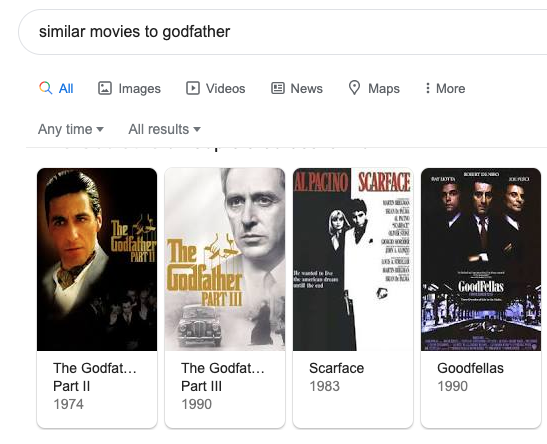

So, I searched Google for similar movies to “Godfather” and here is what I got.

Output is very similar to our model recommendations. In our DataFrame there are no movies such as Scarface and Goodfellas, so that's the reason why we didn't get those two.

There can be further improvments with many other factors such as:
* other members with similar tastes and preferences on specific streaming service  
* user's interaction with streaming's service (history, how user rated other titles,...) 

But, for small DataFrame our model is working very good. :)



